# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План выполнения работы

<br><b>1.Анализ тех процесса. Подготовка данных</b>
<br> - Подготовка данных
<br> - Выбор и обработка данных влияющих на температуру.
<br> - Очистка данных от выбрасов и аномалей. 
<br> - Объеденение в одну таблицу.

<br><b>2. Подбор наиболее эффективной модели</b>
<br> - Проверке на мультиколлинеарность
<br> - Разбивка на обучающую и тестовую выборки
<br> - Выбор моделей по целевому показателю (регрессия) 
* Линейная регрессия
* Дерево принятия решений для регрессии
* Случайный лес для регрессии                   
* Ансамбль LightGBM для регрессии    
* Нейронная сеть

<br> - Подбор параметров выбранных моделей для выбора максимально эффективной.
<br> - Анализ важности факторов
<br> - Тестирование максимально эффективных моделей

<br><b>3.Отчёт

## Анализ тех процесса

<b>Описание</b>

<b>Результаты измерения температуры:</b> 
<br>Все пропуски заменим нолями. Время между замерами посчитаем в секундах.
<br>Сгруппируем записи по котлам (колонка key), в сгруппированную таблицу выведем начальную и конечную температуры.    
Удалим все записи, где последнее измерение температуры равно 0, т.к. конечная температура это целевой признак, а создание синтетического целевого признака может ухудшить результат работы модели.
Удалим все записи, где начальная температура ниже 1500, так как это аномально холодные котлы которые встречаются очень редко
<br>    
<b>Данные об электродах</b>
    <br>Подсчитаем затраченное на нагрев времени (в секундах) сумма всех нагреваний котла.
    <br>Сгруппируем записи по котлам (колонка key)
    В сгруппированной таблице посчитаем среднюю активную и реактивную мощность, а так же количества нагреваний
<br>    
<b>Данные о подаче сыпучих материалов и
Данные о проволочных материалах </b>
    <br>Заполним все пропуски нолями, так как столбцы с пропусками это те добавки которые не попали в котел.
    <br>Найдём столбцы с низкими суммарными значениями (несколько котлов), удалим записи с добавлением таких присадок 
    <br>Удалим сами столбцы, так такой признак будет бесполезен.    
<br>    
<b>Данные о продувке сплава газом</b>
 <br>    Оставим без изменений так как таблица уже сгруппирована по котлам
   

### Реализация

#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.scorer import make_scorer
import re
from tqdm.auto import tqdm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor 
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import cross_val_score
from decimal import Decimal
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping   

#### Пути к файлам

In [2]:
DATA_SET_LOCAL_PATH = './datasets/'
DATA_SET_YP_PATH = '/datasets/final_steel/'
DATA_PROJECT_DIR='./project_data/'

#### Описание функций для анализа тех процесса

In [3]:
def save_file_csv(data,file_name):
    try:
        data.to_csv(DATA_PROJECT_DIR+file_name, index=False)     
    except:
        print('Файл не сохранен. Директория не существует: ',DATA_PROJECT_DIR)
def disp_font_size(text,font_size=3):
    display(HTML(f"<font size='{font_size}'>{text}</font>"))
def get_data(file_name,title='',path=''):
    """
    Функция для загрузки данных из файла и ввода информации об этих данных
    Функция возвращает pdndas.DataFrame с данными загруженными из файла
    """
    
    try:
        data = pd.read_csv(DATA_SET_LOCAL_PATH+file_name)
    except:
        data = pd.read_csv(DATA_SET_YP_PATH+file_name)
    print('===================')
    display(f"{file_name} - {title}")    
    print('===================')
    display(data.info())
    display(data.head(5))
    print('===================')
    return data

def get_stat(data, draw=False, bins=20):
    """
    Функция для вывода статистических данных о столбце (Series):
    Средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.
    При draw = True на экран выводятся boxplot,  distplot с отображением Q1, Q3 и Q1-3*irq,Q3+3*irq
    Функция возвращает границы выбросов (Q1-3*irq, Q3+3*irq)
    """
    q_1 = data.quantile(0.25, interpolation='nearest')
    q_3 = data.quantile(0.75, interpolation='nearest')
    irq = q_3 - q_1
    out_l = q_1 - 3*irq
    out_r = q_3 + 3*irq    
    print(f"Среднее: {data.mean()} || Медиана: {data.median()} \n")
    print(f"Минимум: {data.min()} || Максимум: {data.max()} \n")   
    print(f"25%-квартилей: {q_1}  || 75%-квартилей: {q_3} \n")  
    print(f"Выьросы q_1 - 3*irq: {out_l} || q_3 + 3*irq : {out_r} \n")      
    
    if draw:
        fig, ax = plt.subplots(1,2,figsize=(17, 3))
        sns.boxplot(data, ax=ax[0])
        sns.distplot(data, ax=ax[1],bins=bins) 
        plt.axvline(q_1,color='g',linestyle='--') 
        plt.axvline(q_3,color='g',linestyle='--')
        plt.axvline(out_l,color='r',linestyle='--') 
        plt.axvline(out_r,color='r',linestyle='--')
        plt.show()   
    return out_l, out_r

#### Перевод имен колонок

In [4]:
# Список соответствия названий колонок к их переводу
# И функции для работы с этим списком

columns_name = {
     'temp_first':'Первый замер температуры'
    ,'temp_last':'Последний замер температуры'
    ,'delta_time':'Время между замерами'
    ,'time_measur':'Время замера'
    ,'temperature':'Температура'
    ,'begin_heat':'Начало нагрева дугой'
    ,'end_heat':'Конец нагрева дугой'
    ,'active_power':'Активная мощность'
    ,'reactive_power':'Реактивная мощность'
    ,'time_heat':'Время нагрева'
    ,'gas':'Газ 1'
    ,'time_heat_sum':'Суммарное время нагрева'
    ,'active_power_mean':'Средняя активная мощность'
    ,'reactive_power_mean':'Средняя реактивная мощность'
    , 'count_heat':'Количество нагревов'
}
def get_keybyval(val,dc=columns_name):
    """
    key by value in dict
    """
    for idn, v in dc.items():
        if v == val:
            return(idn)
    return val   

def rename_colbyvals(data,vals,dc=columns_name):
    """
    rename columns by list of vals
    using columns name dict
    """
    for val in vals:
        data = data.rename(columns={val:get_keybyval(val)})
    return data
def print_coldisc(vals,dc=columns_name):
    """
    print col name from 
    """
    col_n = []
#     end = ', '
    for col in vals:
#         if col == vals[-1]: 
#             end = '\n'
        try:
            col_n.append(dc[col]) #+= f"{}{end}"
        except:
            col_n.append(col) #col_n += f"{col}{end}"  
    return(col_n)   

#### Результаты измерения температуры

In [5]:
#Список Дата Фреймоф с признаками
data_features = [] 

In [6]:
data_temp = get_data('data_temp.csv', 'Результаты измерения температуры') 

'data_temp.csv - Результаты измерения температуры'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [7]:
#Переименование столбцы для удобства работы
data_temp = rename_colbyvals(data_temp,['Время замера','Температура'])
#Изменение типов данных в столбцах с датой и временем
data_temp['time_measur'] = pd.to_datetime(data_temp['time_measur'], format='%Y.%m.%d %H:%M:%S')
print(data_temp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key            15907 non-null int64
time_measur    15907 non-null datetime64[ns]
temperature    13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB
None


In [8]:
#Заполнение пропусков нолями
data_temp = data_temp.fillna(0)

In [9]:
#Подсчёт времени между замерами (в секундах)
#Вывод начальной и конечной температуры
data_temp = (

                data_temp.sort_values(by = ['key','time_measur'])
                .groupby('key')
                .agg(
                     time_measur_first = ('time_measur','first'),
                     time_measur_last = ('time_measur','last'),
                     temp_first = ('temperature','first'),
                     temp_last = ('temperature','last')
                    )
                .assign(
                        delta_time = (lambda x: (x['time_measur_last'] - x['time_measur_first'])
                                      .dt.total_seconds().astype('int')                                                               
                                     )
                       )
            )
data_temp = data_temp.drop(columns=['time_measur_first','time_measur_last'])
display(data_temp)

,temp_first,temp_last,delta_time
key,,,
1,1571.0,1613.0,861
2,1581.0,1602.0,1305
3,1596.0,1599.0,1300
4,1601.0,1625.0,388
5,1576.0,1602.0,762
...,...,...,...
3237,1569.0,0.0,1299
3238,1584.0,0.0,749
3239,1598.0,0.0,3148


In [10]:
temp_data_begin_size = data_temp.shape[0]
#Удаляем все записи, где последнее измерение температуры равно 0
zero = data_temp.loc[data_temp['temp_last'] == 0].index
report_tl_zero = len(zero)
data_temp = data_temp.drop(zero)
del zero
report_tl_zero_pr = round(report_tl_zero/temp_data_begin_size*100,2)
print(f"Нулевое значение температуры в {report_tl_zero} записях - {report_tl_zero_pr}%")

Нулевое значение температуры в 739 записях - 22.98%


Среднее: 1588.4057327412193 || Медиана: 1588.0 

Минимум: 1191.0 || Максимум: 1679.0 

25%-квартилей: 1572.0  || 75%-квартилей: 1605.0 

Выьросы q_1 - 3*irq: 1473.0 || q_3 + 3*irq : 1704.0 



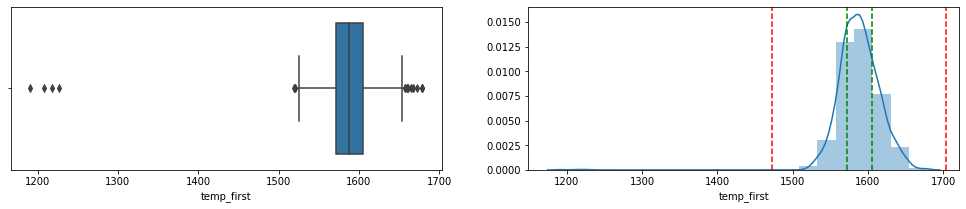

In [11]:
out_l, out_r = get_stat(data_temp['temp_first'],draw=True)

In [12]:
#Удаляем все записи, где начальная температура попала в выбросы

out = (
          data_temp.loc[(data_temp['temp_first'] < out_l)
                  | (data_temp['temp_first'] > out_r)].index
       )
report_tl_out = len(out)
data_temp = data_temp.drop(out)                        
del out
report_tl_out_pr = round(report_tl_out/temp_data_begin_size*100,2)
print(f"Выбросы обнаружены в  {report_tl_out} записях - {report_tl_out_pr}%")

Выбросы обнаружены в  4 записях - 0.12%


Среднее: 1595.3380509502629 || Медиана: 1593.0 

Минимум: 1541.0 || Максимум: 1700.0 

25%-квартилей: 1587.0  || 75%-квартилей: 1599.0 

Выьросы q_1 - 3*irq: 1551.0 || q_3 + 3*irq : 1635.0 



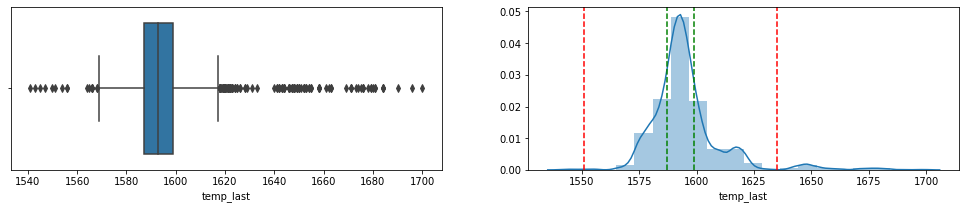

In [13]:
_, _ = get_stat(data_temp['temp_last'],draw=True)

In [14]:
data_temp.count()

temp_first    2473
temp_last     2473
delta_time    2473
dtype: int64

In [15]:
data_features.append(data_temp)
del data_temp

#### Данные об электродах

In [16]:
data_arc = get_data('data_arc.csv', 'Данные об электродах')

'data_arc.csv - Данные об электродах'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [17]:
#Переименование столбцы для удобства работы

data_arc = rename_colbyvals(data_arc,['Начало нагрева дугой','Конец нагрева дугой'
                                 ,'Активная мощность','Реактивная мощность'])
#Изменение типов данных в столбцах с датой и временем
data_arc['begin_heat'] = pd.to_datetime(data_arc['begin_heat'], format='%Y.%m.%d %H:%M:%S')
data_arc['end_heat'] = pd.to_datetime(data_arc['end_heat'], format='%Y.%m.%d %H:%M:%S')
print(data_arc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key               14876 non-null int64
begin_heat        14876 non-null datetime64[ns]
end_heat          14876 non-null datetime64[ns]
active_power      14876 non-null float64
reactive_power    14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None


In [18]:
#Подсчёт затраченного на нагрев времени (в секундах)
#Выыод активной и реактивной мощности
data_arc['time_heat'] = ((data_arc['end_heat'] - data_arc['begin_heat'])
                                    .dt.total_seconds().astype('int') 
                                 )
display(data_arc.head(5))

,key,begin_heat,end_heat,active_power,reactive_power,time_heat
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


In [19]:
#Подсчёт количества нагреваний
data_arc = data_arc.groupby('key').agg(
                                        time_heat_sum = ('time_heat', 'sum'),
                                        active_power_mean = ('active_power','mean'),  
                                        reactive_power_mean = ('reactive_power','mean'),
                                        count_heat = ('active_power','count')
                                      )

In [20]:
display(data_arc.sort_values(by='count_heat'))

,time_heat_sum,active_power_mean,reactive_power_mean,count_heat
key,,,,
943,61,0.199899,0.198835,1
2582,109,0.342977,0.340039,1
246,129,0.432823,0.315280,1
343,168,0.583838,0.448890,1
1914,111,0.384023,0.295312,1
...,...,...,...,...
322,2658,0.732406,0.616965,13
2567,1249,0.301025,0.306679,14
1689,4189,1.166433,0.839199,15


In [21]:
data_features.append(data_arc)
del data_arc

#### Данные о подаче сыпучих материалов

In [22]:
data_bulk = get_data('data_bulk.csv', 'Данные о подаче сыпучих материалов (объём)')

'data_bulk.csv - Данные о подаче сыпучих материалов (объём)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [23]:
#Заполнение пропусков нолями
data_bulk = data_bulk.fillna(0).set_index('key')
display(data_bulk.head(5))

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [24]:
#переименование столбцов
for col in data_bulk.columns:
    data_bulk = data_bulk.rename(columns={col:col.lower().replace(' ', '_')})

In [25]:
#поиск столбцов с небольшим количеством значений
display(data_bulk.sum())

bulk_1       9889.0
bulk_2       5567.0
bulk_3     147815.0
bulk_4     105856.0
bulk_5       8241.0
bulk_6      68501.0
bulk_7       7640.0
bulk_8         49.0
bulk_9       1450.0
bulk_10     14658.0
bulk_11     13597.0
bulk_12    638154.0
bulk_13      3260.0
bulk_14    477819.0
bulk_15    360834.0
dtype: float64

In [26]:
#удаление строк со значением в столбце bulk_8
data_bulk = data_bulk.drop(data_bulk.loc[data_bulk['bulk_8']>0].index)
#удаление столбца bulk_8
data_bulk = data_bulk.drop(columns=['bulk_8'])

In [27]:
display(data_bulk.head(5))

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [28]:
data_features.append(data_bulk)
del data_bulk

#### Данные о проволочных материалах

In [29]:
data_wire = get_data('data_wire.csv', 'Данные о проволочных материалах (объём)') 

'data_wire.csv - Данные о проволочных материалах (объём)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#Заполнение пропусков нолями
data_wire = data_wire.fillna(0).set_index('key')
display(data_wire.head(5))

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#переименование столбцов
for col in data_wire.columns:
    data_wire = data_wire.rename(columns={col:col.lower().replace(' ', '_')})

In [32]:
#поиск столбцов с небольшим количеством значений
display(data_wire.sum())

wire_1    308236.830606
wire_2     54572.931650
wire_3     11937.408916
wire_4       804.199781
wire_5        15.132000
wire_6      3505.239099
wire_7       110.429080
wire_8      1018.878666
wire_9       990.516814
dtype: float64

In [33]:
#удаление строк со значением в столбце bulk_8
data_wire = data_wire.drop(data_wire.loc[data_wire['wire_5']>0].index)
#удаление столбца bulk_8
data_wire = data_wire.drop(columns=['wire_5'])

In [34]:
display(data_wire.head(5))

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
data_features.append(data_wire)
del data_wire

#### Данные о продувке сплава газом

In [36]:
data_gas = get_data('data_gas.csv','Данные о продувке сплава газом') 

'data_gas.csv - Данные о продувке сплава газом'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [37]:
#переименование столбца
data_gas = rename_colbyvals(data_gas,['Газ 1']).set_index('key')

In [38]:
display(data_gas.sort_values(by='gas'))

,gas
key,
866,0.008399
1047,0.016696
2103,0.263029
2356,0.275081
355,0.325733
...,...
117,50.581035
2570,51.380229
2110,52.142373


In [39]:
data_features.append(data_gas)
del data_gas

#### Общая таблица признаков

In [40]:
#Объединение таблиц со всесеми признаками по пригципу inner
data_features_merge = data_features[0]
for data_num in range(1,len(data_features)):
    data_features_merge = (
                        data_features_merge.
                        merge(data_features[data_num], on = 'key', how = 'inner')
                    )

display(data_features_merge.info())
display(data_features_merge.sort_values(by='key'))

report_bad_keycount = ( (temp_data_begin_size-report_tl_zero-report_tl_out)
                       - data_features_merge.shape[0]
                      )
display(f"В таблицу не попали {report_bad_keycount} партий")
del data_features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 30 columns):
temp_first             2324 non-null float64
temp_last              2324 non-null float64
delta_time             2324 non-null int32
time_heat_sum          2324 non-null int32
active_power_mean      2324 non-null float64
reactive_power_mean    2324 non-null float64
count_heat             2324 non-null int64
bulk_1                 2324 non-null float64
bulk_2                 2324 non-null float64
bulk_3                 2324 non-null float64
bulk_4                 2324 non-null float64
bulk_5                 2324 non-null float64
bulk_6                 2324 non-null float64
bulk_7                 2324 non-null float64
bulk_9                 2324 non-null float64
bulk_10                2324 non-null float64
bulk_11                2324 non-null float64
bulk_12                2324 non-null float64
bulk_13                2324 non-null float64
bulk_14                2324 non-null float64

None

,temp_first,temp_last,delta_time,time_heat_sum,active_power_mean,reactive_power_mean,count_heat,bulk_1,bulk_2,bulk_3,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861,1098,0.975629,0.636648,5,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,1305,811,0.763150,0.499528,4,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,1300,655,0.505176,0.319815,5,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,388,741,0.802313,0.515074,4,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,762,869,0.836793,0.563161,4,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,1137,723,0.802673,0.590194,4,0.0,0.0,21.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2496,1554.0,1591.0,1618,940,0.700511,0.468364,6,0.0,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2497,1571.0,1589.0,717,569,0.737460,0.617090,3,0.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699


'В таблицу не попали 149 партий'

In [41]:
data_features_merge.describe()

,temp_first,temp_last,delta_time,time_heat_sum,active_power_mean,reactive_power_mean,count_heat,bulk_1,bulk_2,bulk_3,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.00000,...,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1587.370912,1593.372203,1899.040878,808.115318,0.669343,0.422481,4.696644,3.435026,1.425559,47.26420,...,120.078313,102.380870,17.592435,3.241876,0.307209,0.980926,0.006374,0.282508,0.317795,11.378396
std,23.626600,11.208029,1323.311276,340.880820,0.197022,3.719067,1.606210,12.424463,19.102530,75.22805,...,84.655967,43.518411,33.644136,27.972523,4.762842,8.702531,0.205926,4.174122,3.460248,6.396955
min,1519.000000,1541.000000,234.000000,57.000000,0.186226,-178.647909,1.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399
25%,1571.000000,1587.000000,1215.000000,581.000000,0.526451,0.392551,4.000000,0.000000,0.000000,0.00000,...,0.000000,73.204559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.282534
50%,1587.000000,1593.000000,1634.500000,778.000000,0.645157,0.488079,5.000000,0.000000,0.000000,0.00000,...,107.000000,101.087998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.100687
75%,1603.000000,1598.000000,2293.250000,993.000000,0.792148,0.592599,6.000000,0.000000,0.000000,80.00000,...,204.000000,127.840439,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.218487
max,1660.000000,1653.000000,23537.000000,4189.000000,1.421416,1.134983,16.000000,185.000000,325.000000,454.00000,...,405.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600,77.995040


Среднее: 1593.3722030981066 || Медиана: 1593.0 

Минимум: 1541.0 || Максимум: 1653.0 

25%-квартилей: 1587.0  || 75%-квартилей: 1598.0 

Выьросы q_1 - 3*irq: 1554.0 || q_3 + 3*irq : 1631.0 



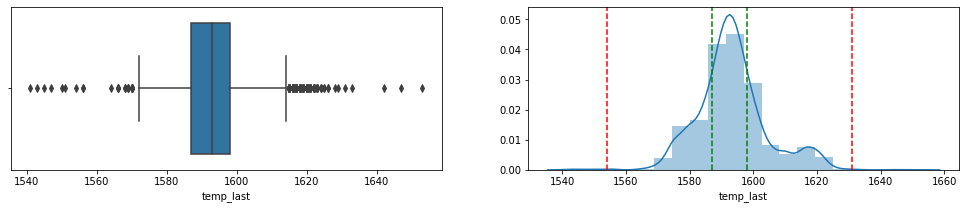

In [42]:
t_last_out_l, t_last_out_r = get_stat(data_features_merge['temp_last'],draw=True)

In [43]:
display((data_features_merge.loc[data_features_merge['temp_last'] > t_last_out_r])
       .sort_values(by='temp_last'))

,temp_first,temp_last,delta_time,time_heat_sum,active_power_mean,reactive_power_mean,count_heat,bulk_1,bulk_2,bulk_3,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,
1804,1658.0,1633.0,2211,1052,0.484453,0.367308,8,0.0,0.0,0.0,...,104.0,147.139206,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.870435
684,1575.0,1642.0,1593,1304,0.972558,0.667831,6,0.0,0.0,106.0,...,206.0,107.265594,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,8.210977
113,1645.0,1647.0,2969,819,0.936464,0.606081,4,0.0,228.0,0.0,...,0.0,7.556640,0.0,96.047951,24.148801,60.094322,0.0,0.0,0.0,25.377930
1563,1628.0,1653.0,2360,932,1.421416,0.988197,3,0.0,0.0,0.0,...,0.0,249.958786,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.906249


<b>Как видно многии выбросы по максимальной температуре отсеялись по другим параметрам.</b>

In [44]:
## Подбор наиболее эффективной модели

### Параметры

In [45]:
#параметры
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 300

#Параметры для отладки
DEBUGING = False               #вывод на экран текущих параметров


R_STATE = 737
N_JOBS = -1  
filled_VehicleType=False

TARGET_NAME = 'temp_last'
TEST_SIZE=0.3

models_params_find = False  #Заменить на True для принудительного запуска поиска параметров
                            #При згачении False программа попвтается взять данные из файла 
switch_to_find_ifno_file = False #Переключаться на перебор параметров 
                                 #если не обнаружен файл c параметрами моделей

### Проверке на мультиколлинеарность

In [46]:
col_count = len(data_features_merge.columns)
data_correlation = pd.DataFrame()
for col_n in range(col_count):
    for col_n2 in range(col_n+1, col_count):
        c_name_1 = data_features_merge.columns[col_n]
        c_name_2 = data_features_merge.columns[col_n2]
        corr = data_features_merge[c_name_1].corr(data_features_merge[c_name_2])
        sign = '+'
        if corr < 0: sign = '-'
        corr = np.abs(corr)    
        data_correlation = data_correlation.append({'col_1':c_name_1,
                                                    'col_2':c_name_2,
                                                    'corr':corr,
                                                    'sign':sign}, 
                                                    ignore_index=True
                                                    )
strong_correlation = (
                        data_correlation.loc[data_correlation['corr'] > 0.9]
                        .sort_values(by='corr', ascending=False)  
                     )
display(strong_correlation)

,col_1,col_2,corr,sign
327,bulk_9,wire_8,0.990008,+


<b>Удалим столбцы с высокой корреляцией</b>

In [47]:
try:
    print('Размер таблицы до удаления ', data_features_merge.shape)
    del_col = strong_correlation['col_2'].values
    print('Удаляем колонки ', del_col)
    data_features_merge = data_features_merge.drop(columns=del_col)
    print('Размер таблицы после удаления ', data_features_merge.shape)
except: None
    

Размер таблицы до удаления  (2324, 30)
Удаляем колонки  ['wire_8']
Размер таблицы после удаления  (2324, 29)


### Разбивка на обучающую и тестовую выборки

In [48]:
def div_features_target(data,targetname):
    """
    Функция для разделения таблицы на признаки и целевой признак
    """
    return data.drop([targetname], axis=1), data[targetname]

In [49]:
train_data, test_data = train_test_split(data_features_merge, 
                                            test_size=TEST_SIZE, random_state=R_STATE)

train_features, train_target = div_features_target(train_data,TARGET_NAME) 
test_features, test_target = div_features_target(test_data,TARGET_NAME)

del train_data, test_data

In [50]:
disp_font_size(f"Тренеровочная выборка {train_features.shape} - {train_target.shape}",4)
disp_font_size(f"Тестовая выборка {test_features.shape} - {test_target.shape}",4)

### Выбор моделей по целевому показателю (регрессия)

#### Функций для telegrem bota

In [51]:
#telegrem bot для оповещений о работк моделей
#++++++++++СОЗДАНИЕ БОТА+++++++
def save_bot_config(tkn):
    """
    Функция для сохранения конфигурации бота
    """
    try:
        import requests
        import json
        config = {'token':tkn,'chat_id':''}
        query = f"https://api.telegram.org/bot{tkn}/getUpdates"
        j = json.loads(requests.get(query).text)
        
        config = {'token':tkn,
                  'chat_id':j['result'][0]['my_chat_member']['from']['id']}
        np.save(DATA_PROJECT_DIR+'config.npy', config)
    except: return 'err'
    return 'ok'

def load_bot_conf():
    """
    Функция для загрузки конфигурации бота
    """
    try:
        config_rq = np.load(DATA_PROJECT_DIR+'config.npy',allow_pickle='TRUE').item()
        return config_rq['token'], config_rq['chat_id']
    except: return False

def make_natrix(token,chat_id):
    """
    Функция для отправки текстового сообщения
    """
    def send_mes(text):
        telegram = get_notifier('telegram')
        telegram.notify(message=text,token=token,chat_id=chat_id)
    return send_mes

def natrix_send_model_list(model_list, natrix_send_f, title=''):
    """
    Функция для отправки списка моделей (DataFrame)
    """    
    mess = ''
    for ind, row in model_list.iterrows():        
        tr_s = row['score']
        if tr_s != '-':
            tr_s = round(tr_s,2)                
        test_s = row['test_score']
        if test_s != '-':
            test_s = round(test_s,2)
        mess += (f"test:{test_s}||tr:{tr_s}||"
               + f"{row['model']}{row['g_param']}\n"
             )    
    mess = re.sub(r" |\'", '', mess)
    mess = f"{title}\n\n" + mess
    try:
        natrix_send_f(mess)
    except:
        print(natrix_send_f)

In [52]:
save_bot_config('')

'err'

In [53]:
try:
    token, chat_id = load_bot_conf()
    from notifiers import get_notifier    
    natrix_message = make_natrix(token, chat_id)
    bot_ok = True
    print('Бот активен!')
except:
    natrix_message = 'Бот не активен!'
    bot_ok = False
    print('Бот не активен!')

Бот активен!


### Модели из библиотеки sklearn: 
- Дерево принятия решений для регрессии
- Случайный лес для регрессии
- Ансамбль LightGBM для регрессии
- Линейная регрессия

#### Описание функций для моделирования

In [54]:
#функции для создания и работы с моделями: 
#  Дерево принятия решений для регрессии
#  Случайный лес для регрессии
#  Ансамбль LightGBM для регрессии
#  Линейная регрессия

def display_metric(score, scorer, title=''): 
    """
    Функция для вывода метрик
    """           
    if isinstance(scorer, str):
        scorer_name = scorer.split(' ')[1]
    else:
        scorer_name = re.sub(r".*\(|\,.*|\)", '', str(scorer))

    disp_font_size(f" {title} {scorer_name.upper()}: = {score}",5)  
def score_cv(model, features, target, scorer, cv=5, mean=True):
    train_time = time.time()
    result = cross_val_score(model, features, target, scoring=scorer, cv=cv, n_jobs=N_JOBS) 
    train_time = round(time.time() - train_time,2)
    if mean: result = round(result.mean(),4)
    return result, train_time 

def  make_pipe(model, **kwargs):
    return Pipeline([
    ('scale', StandardScaler()),
    ('clf', model)
])

def make_clf(model_type, **kwargs):
    if model_type == 'RndForestReg':
        model = make_pipe(RandomForestRegressor(random_state=R_STATE, **kwargs))
    elif model_type == 'DecTreeReg':        
        model = make_pipe(DecisionTreeRegressor(random_state=R_STATE, **kwargs))
    elif model_type == 'LinearReg':
        model = make_pipe(LinearRegression(**kwargs))    
    elif model_type == 'LGBMReg':
        model = make_pipe(LGBMRegressor(boosting_type='gbdt',random_state=R_STATE, **kwargs))       
    else: return 0, 'Тип модели не найден'
    return model

#Таблица для хранения лучших результатов моделей
columns_model = ['model','g_param','Score']
models_valid = pd.DataFrame(columns=columns_model)    

def get_model(params, train_features, train_target):    
    model = make_clf(params['model'], **params['g_param'])
    pbar = tqdm(total = 1)
    model.fit(train_features, train_target)   
    pbar.update(1)    
    pbar.close()        
    return model


def get_param_list(kwargs):
    params_list = pd.DataFrame()    
    if len(kwargs) > 0:        
        new_str = pd.Series()
        for key, param in kwargs.items():
            old_param_list = params_list.copy()
            params_list = pd.DataFrame()
            num_params = len(old_param_list)
            if num_params < 1 : num_params=1
            for str_ind in range(num_params):
                if isinstance(param, range) | isinstance(param, np.ndarray): 
                    for p in param:
                        try:
                            new_str = old_param_list.iloc[str_ind]
                        except: None
                        if isinstance(p, float): p = round(p,4)
                        new_str[key] = p
                        params_list = params_list.append(new_str, ignore_index=True)                    
                else:
                    try:
                        new_str = old_param_list.iloc[str_ind]
                    except: None
                    new_str[key] = param
                    params_list = params_list.append(new_str, ignore_index=True)
    if len(params_list) < 1: params_list.loc[0,'no_param']='no_param'
    return params_list

    
def get_model_params(model_type, features, target, scorer, title=''
                 , n_str=7, disp_metr=True 
                 , returnModel=False, debug=False, **kwargs):

    """
    Функция для создания модели  
    
    """
    
    columns_model = ['model','g_param','train_time','score']
    models_param = pd.DataFrame(columns=columns_model)    

       
    print('==========================')    
    disp_font_size(f"Модель: {MODEL_TEXT_NAME[model_type]} {title} <br>",5)    
    params_list = get_param_list(kwargs)
    pbar = tqdm(total = len(params_list))
    params = {}
    for ind, row in params_list.iterrows():
        for col_n, val in row.items():
            if col_n != 'no_param':
                if isinstance(val, str): params[col_n] = val
                elif float(val)%1>0: params[col_n] = float(val)
                else: params[col_n] = int(val)              
        model = make_clf(model_type, **params)  
        try:
            score, train_time = score_cv(model, features, target, scorer)            
            if debug: print(f'{kwargs}|{score}')              
            models_param = models_param.append({'model': model_type
                                               ,'g_param':{**params}                                                
                                               ,'train_time':train_time
                                               ,'score':score}
                                               , ignore_index=True)   
        except:
            models_param = models_param.append({'model': model_type
                                               ,'g_param':{**params}                                                
                                               ,'train_time':'Err'
                                               ,'score':'Err'}
                                               , ignore_index=True)   

        pbar.update(1)      
    pbar.close()        
    #Вывод результатов    
    models_param = models_param.loc[~models_param['score'].isin(['Err','-'] )]
    models_param = models_param.sort_values(by='score', ascending=False).reset_index(drop=True)
 
    
    if disp_metr: 
        if n_str > 0: display(models_param.head(n_str))
        try:
            disp_font_size(re.sub(r'[\{\}]', '', str(models_param.loc[0,'g_param'])),5)
        except:    
            disp_font_size('Нет параметров')
        disp_font_size(f"Время: {models_param.loc[0,'train_time']}",5)
        display_metric(models_param.loc[0,'score'], scorer)             
        
  
    return models_param

def disp_model_result(model, test_features, test_target, scorer):   
    """
    Функция для подсчёта метрики и вывода результатов
    """
    try:
        pred_time = time.time()    
        predict = model.predict(test_features)
        pred_time = round(time.time() - pred_time,2)
    except:
        score = 'disp_model_result - Err'
    min_best = not scorer[1]
    score = round(scorer[0](test_target,predict),2) 
    if min_best: score = score * -1    
    #disp_font_size(MODEL_TEXT_NAME[row['model']],5)  
    #disp_font_size(re.sub(r'[\{\}]', '', str(row['g_param'])),4)  
    display_metric(score, str(scorer[0]))        
    return score, pred_time


def models_test(params, features, target, test_features, test_target, scorer):
    models_p = pd.DataFrame(columns=['model','g_param','pred_time','test_score'])    
    tested_model = pd.DataFrame()
    for i, row in params.iterrows():
        try:
            model = get_model(row, features, target)        
            score, pred_time = disp_model_result(model, test_features, test_target, scorer)
        except: 
            print('models_test - Модель не создана') 
        tested_model = row[['model','g_param']]
        tested_model['test_score'] = score
        tested_model['pred_time'] = pred_time
        models_p = models_p.append(tested_model, ignore_index=True) 
    return models_p.sort_values(by='test_score', ascending=True).reset_index(drop=True)
        
def models_serch(params, features, target, test_features=None
                 , test_target=None
                 , scorer=[mean_absolute_error,False]
                 , n_str=7, test=False, test_num=5):
    models_p = pd.DataFrame()   
    if test: n_str = 0
    my_scorer = make_scorer(scorer[0], greater_is_better=scorer[1])      
    for model, params in params.items():
        model_name = re.sub(r".*\_", '', str(model))    
        log = get_model_params(model_name, features, target, my_scorer
                               , n_str=n_str, disp_metr=True
                               , **params, debug=DEBUGING)    
        log = log.head(test_num)
        sort_column = 'score'
        test_num_str = test_num -1
        log['pred_time'] = '-'
        log['test_score'] = '-'
        
        if test:
            print('======================')
            disp_font_size("Результаты на тестовой выборке",5)  
            if test_num < len(log): test_num_str = test_num -1
            else: test_num_str = len(log)
            models_test_p = models_test(log.head(test_num_str+1)
                                        , features, target
                                        , test_features, test_target
                                            , scorer=scorer)
            display(models_test_p)                
          
            log.loc[0:test_num_str,'pred_time'] = models_test_p.loc[0:test_num_str,'pred_time']
            log.loc[0:test_num_str,'test_score'] = models_test_p.loc[0:test_num_str,'test_score']
            sort_column = 'test_score'      
            
        models_p = models_p.append(log, ignore_index=True,sort=False)   
    result = models_p.loc[~models_p[sort_column].isin(['Err','-'] )]
    return  (result.sort_values(by=sort_column, ascending=False)
                 .reset_index(drop=True)
            )

In [55]:
#перечень моделей
MODEL_TEXT_NAME = {'LinearReg':'Линейная регрессия'
                    ,'DecTreeReg':'Дерево принятия решений для регрессии' 
                    ,'RndForestReg':'Случайный лес для регрессии'
                    ,'LGBMReg':'Ансамбль LightGBM для регрессии'
                    , 'Keras':'Модели Keras Sequential c 1-3 layers Dense'}

#### Подбор параметров моделей для выбора максимально эффективной

In [56]:
#models_params_find = False  #Заменить на True для принудительного запуска поиска параметров
                            #При згачении False программа попвтается взять данные из файла                
models_bigrng_params_find = models_params_find    
if ~models_bigrng_params_find:
    try:
        model_list = pd.read_csv(DATA_PROJECT_DIR+'model_list.csv')
    except:
        model_list = 'Файл не найден. models_params_find = True для поиска параметров.'
        if switch_to_find_ifno_file:
            models_bigrng_params_find = True

if models_bigrng_params_find:
    models_param = {
             'LinearReg':{},
             'DecTreeReg':{'max_depth': range(1,101,10)},
             'RndForestReg':{'max_depth': range(1,101,10), 'n_estimators': range(1,101,10)},
             'LGBMReg':{'max_depth': range(1,101,10),'n_estimators': range(1,101,10), 
                           'learning_rate': np.arange(0.1,1.1,0.3)}
            }            
    
    model_list = models_serch(models_param, train_features, train_target
                                          , test_features,  test_target
                                          , scorer=[mean_absolute_error,False]
                                          , test=False, test_num=5)
    save_file_csv(model_list,'model_list.csv')    
    natrix_send_model_list(model_list
                       ,natrix_message,'Модели с большими шагом')    

if isinstance(model_list, pd.DataFrame):
    display(model_list)
else:
    display(model_list)        

,model,g_param,train_time,score,pred_time,test_score
0,LinearReg,{},1.91,-5.7613,-,-
1,LGBMReg,"{'learning_rate': 0.7, 'max_depth': 1, 'n_estimators': 81}",0.06,-5.8091,-,-
2,LGBMReg,"{'learning_rate': 0.7, 'max_depth': 1, 'n_estimators': 91}",0.07,-5.8158,-,-
3,LGBMReg,"{'learning_rate': 0.1, 'max_depth': 51, 'n_estimators': 81}",0.18,-5.8180,-,-
4,LGBMReg,"{'learning_rate': 0.1, 'max_depth': 71, 'n_estimators': 81}",0.18,-5.8180,-,-
5,LGBMReg,"{'learning_rate': 0.1, 'max_depth': 91, 'n_estimators': 81}",0.19,-5.8180,-,-
6,RndForestReg,"{'max_depth': 31, 'n_estimators': 71}",0.96,-5.9430,-,-
7,RndForestReg,"{'max_depth': 91, 'n_estimators': 71}",1.03,-5.9440,-,-
8,RndForestReg,"{'max_depth': 81, 'n_estimators': 71}",0.88,-5.9440,-,-
9,RndForestReg,"{'max_depth': 71, 'n_estimators': 71}",0.93,-5.9440,-,-


In [57]:
#Из лусших комбинаций параметров (top_models по каждой моделе)
#Составляем диапазон перебора параметров от мин до макс значения каждого параметра
def str_to_dict(str_p):
    """
    Функция переводит строку формата {'x':n,'y':k} в словарь
    """
    str_p = re.sub(r"\{|\}|\s|\'", '', str(str_p)).split(',')
    dic_p = {}
    for p in str_p:
        spl_p = p.split(':')
        if (spl_p[0] != ''):
            if spl_p[1].replace('.', '').isdigit():
                try:
                    dic_p[spl_p[0]] = int(spl_p[1])
                except:
                    dic_p[spl_p[0]] = float(spl_p[1])
            else:
                dic_p[spl_p[0]] = spl_p[1]
    return dict(dic_p)

def get_max_min_range(model_list, top_models):
    """
    Функция приниает список моделий, а возвращает DataFrame 
    с моделями и диапазонами значений для каждого параметра
    """
    unique_models = model_list['model'].unique()    
    params_range_list = {}
    for model in unique_models:
        rng_p = pd.DataFrame()
        bm_lst = pd.DataFrame()
        top_models_params =  (
                             (model_list.loc[model_list['model'] == model][['model','g_param']])
                             .head(top_models)
                             )
        for ind, row in top_models_params.iterrows():  
            p = row['g_param']
            if isinstance(p, str):
                p = str_to_dict(p)                            
            bm_lst = bm_lst.append(p, ignore_index=True)
        rng_p['max'] = bm_lst.max()
        rng_p['min'] = bm_lst.min()   
        md_par = {}
        for ind, row in rng_p.iterrows():
            r_start = row['min']
            r_end = row['max']
            if (r_start % 1 > 0) or (r_end % 1 > 0):
                rng = np.arange(r_start.astype('float'),r_end.astype('float')+0.1,0.1)
            else:
                rng = range(r_start.astype('int'),r_end.astype('int')+1)
            md_par[ind] = rng
                
        params_range_list[model] = md_par                          
    return params_range_list

In [58]:
#Подбор параметров моделей с маленьким шагом
#Но с сокрощенным диапазоном
# models_detail_params_find = True
try:
    best_models_params = get_max_min_range(model_list,3) 
except: 
    best_models_params = "Нет списка моделий для поиска get_max_min_range"

display(best_models_params)
models_detail_params_find = models_params_find 
if ~models_detail_params_find:
    try:
        model_list_detail = pd.read_csv(DATA_PROJECT_DIR+'model_list_detail.csv')
        
    except:
        model_list_detail = 'Файл не найден. models_detail_params_find = True для поиска параметров.'
        if switch_to_find_ifno_file:
            models_detail_params_find = True

if models_detail_params_find:  
    model_list_detail = models_serch(best_models_params, train_features, train_target
                                          , test_features,  test_target
                                          , scorer=[mean_absolute_error,False]
                                          , test=True, test_num=1)
    model_list_detail[['score', 'test_score']] *= -1
    save_file_csv(model_list_detail,'model_list_detail.csv')    
    natrix_send_model_list(model_list_detail,natrix_message,'Модели с маленьким шагом')        

{'LinearReg': {},
 'LGBMReg': {'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
  'max_depth': range(1, 52),
  'n_estimators': range(81, 92)},
 'RndForestReg': {'max_depth': range(31, 92), 'n_estimators': range(71, 72)},
 'DecTreeReg': {'max_depth': range(1, 22)}}

In [59]:
display(model_list_detail)

,model,g_param,train_time,score,pred_time,test_score
0,LGBMReg,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 82}",0.06,5.7692,0.00,5.78
1,RndForestReg,"{'max_depth': 31, 'n_estimators': 71}",0.97,5.9430,0.02,6.14
2,DecTreeReg,{'max_depth': 6},0.04,6.9059,0.00,7.42
3,LinearReg,{},0.05,5.7613,0.00,12.46


### Нейронные сети библиотека Keras: 

In [60]:
def create_keras_model(features, target, lr=0.01, layer_d=1,
                       loss='mean_squared_error', metrics=['mae'], epochs=1000, verbose=0):
    callback = EarlyStopping(monitor='val_mae', restore_best_weights=True,
                              patience=10, min_delta=0.05,
                              verbose=verbose)     
    model = keras.models.Sequential()
    f_n = features.shape[1]
    u_n = f_n
    for l in range(1,layer_d+1):
        if l >= layer_d: u_n=1           
        model.add(keras.layers.Dense(units=u_n, input_dim=f_n))
    
    optimizer = Adam(learning_rate=lr)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    train_time = time.time()
    history = model.fit(features, target, validation_split=0.3, epochs=epochs,
                        callbacks=[callback], verbose=verbose)  
    train_time = round(time.time() - train_time,2)
    return model, train_time, len(history.history['loss'])

def keras_model_result(model, features, target
                                 , metrik_name = 'mae', print_result=True):
    pred_time = time.time()
    results = model.evaluate(features, target, verbose=0)
    pred_time = round(time.time() - pred_time,2)
    if print_result:
        disp_font_size(f"Тестовая выборка loss: {round(results[0],4)}"
                       +f" || {metrik_name}:{round(results[1],4)}")
    return results, pred_time 

def keras_models_serch(features, target, 
                       test_features, test_target, 
                       lr_range, layer_d=1, eph=1000, 
                       model_type='KerasLinearReg', print_result=False):
    
    test_columns_model = ['model','g_param','train_time','score','pred_time','test_score']
    keras_models_param = pd.DataFrame(columns=test_columns_model)
    
    for i in tqdm(lr_range):    
        model, train_time, epochs_n = create_keras_model(features, target, 
                                                         lr=i, layer_d=layer_d, epochs=eph)
    
        if print_result:
            print(f"lr: {i} || last_epoch: {epochs_n}")
        score, _              = keras_model_result(model, features, target
                                              , metrik_name = 'mae', print_result=print_result)
    
        test_score, pred_time = keras_model_result(model, test_features, test_target
                                              , metrik_name = 'mae', print_result=print_result)    
   
        keras_models_param = keras_models_param.append({'model': model_type, 
                                    'g_param':{'layer_d':layer_d,'lr':round(i,5),'eph':epochs_n},
                                    'train_time':train_time,'score':score[1],
                                    'pred_time':pred_time,'test_score':test_score[1],
                                   },ignore_index=True)  
    return keras_models_param.sort_values(by='test_score').head(3)

In [61]:
test_columns_model = ['model','g_param','train_time','score','pred_time','test_score']
keras_models_all = pd.DataFrame(columns=test_columns_model)

sc = StandardScaler()
train_features_sc = sc.fit_transform(train_features)
test_features_sc = sc.transform(test_features)
keras_models_params_find = models_params_find
if ~keras_models_params_find:
    try:
        model_list_detail = pd.read_csv(DATA_PROJECT_DIR+'model_list_detail.csv')
        
    except:
        model_list_detail = 'Файл не найден. models_params_find = True для поиска параметров.'
        if switch_to_find_ifno_file:
            keras_models_params_find = True       
        
if keras_models_params_find:
    keras_models = keras_models_serch(train_features_sc, train_target,
                                       test_features_sc, test_target, 
                                       [0.05], #np.arange(0.04,0.051,0.01), 
                                       eph=2000, model_type='Keras_1L_SC', print_result=False)
    display(keras_models)
    keras_models_all = pd.concat([keras_models_all, keras_models])
    
    
    keras_models = keras_models_serch(train_features, train_target,
                                       test_features, test_target, 
                                       [0.0841], #[round(0.0001 * x,4)  for x in range(1,1000,10)], 
                                       model_type='Keras_1L', print_result=False)
    display(keras_models)
    keras_models_all = pd.concat([keras_models_all, keras_models])
    
    keras_models = keras_models_serch(train_features, train_target,
                                       test_features, test_target, 
                                       [0.0161], #[round(0.0001 * x,4)  for x in range(1,1000,10)], 
                                       layer_d=2, model_type='Keras_2L', 
                                       print_result=False)
    display(keras_models)
    keras_models_all = pd.concat([keras_models_all, keras_models])
    
    keras_models = keras_models_serch(train_features, train_target,
                                       test_features, test_target, 
                                       [0.0191], #[round(0.0001 * x,4)  for x in range(1,1000,10)], 
                                       layer_d=3, model_type='Keras_3L', 
                                       print_result=False)
    display(keras_models)
    keras_models_all = pd.concat([keras_models_all, keras_models])
    
    keras_models_all = keras_models_all.sort_values(by='test_score')
    save_file_csv(keras_models_all,'keras_models_all.csv')     
    natrix_send_model_list(keras_models_all,natrix_message,'Модели Keras')     

In [62]:
display(keras_models_all)

,model,g_param,train_time,score,pred_time,test_score


In [63]:
try:
    all_model_list = (pd.concat([model_list_detail,keras_models_all]
                                 ,ignore_index=True)
                      .sort_values(by='test_score')
                     )
except:    
    #Параметры лучшей модели которые найдутся автоматически
    #Если в разделе "Параметры" установить 
    #switch_to_find_ifno_file = True
    all_model_list = pd.DataFrame(data={'model':['LGBMReg'],
                                   'g_param':[{'learning_rate':0.2,
                                              'max_depth': 3,
                                              'n_estimators': 82}]
                     })

In [64]:
display(all_model_list)

,model,g_param,train_time,score,pred_time,test_score
0,LGBMReg,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 82}",0.06,5.7692,0.00,5.78
1,RndForestReg,"{'max_depth': 31, 'n_estimators': 71}",0.97,5.9430,0.02,6.14
2,DecTreeReg,{'max_depth': 6},0.04,6.9059,0.00,7.42
3,LinearReg,{},0.05,5.7613,0.00,12.46


### Лучшая модель из рассмотренных

In [65]:
report_bm_params = all_model_list.loc[0]
display(report_bm_params)
params = str_to_dict(all_model_list.loc[0]['g_param'])

best_model = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LGBMRegressor(boosting_type='gbdt',random_state=R_STATE, **params))
])

model                                                            LGBMReg
g_param       {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 82}
train_time                                                          0.06
score                                                             5.7692
pred_time                                                              0
test_score                                                          5.78
Name: 0, dtype: object

In [66]:
best_model.fit(train_features, train_target)
best_score = disp_model_result(best_model, test_features, test_target, 
                  scorer=[mean_absolute_error,True])[0]

### Анализ важности факторов

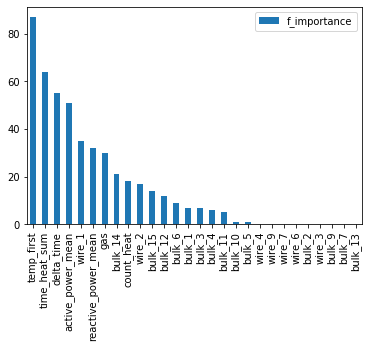

In [67]:
f_importances_all = pd.DataFrame(data={'f_importance': best_model['clf'].feature_importances_}, 
             index=train_features.columns).sort_values(by='f_importance', ascending=False)
# print(f_importances)
f_importances_all.plot.bar()

In [68]:
no_importances = list(f_importances_all.loc[f_importances_all['f_importance'] < 1].index)

In [69]:
train_features_fi = train_features.drop(columns=no_importances)
test_features_fi = test_features.drop(columns=no_importances)
fi_df = f_importances_all.drop(no_importances)
best_model.fit(train_features_fi, train_target)
prev_score = disp_model_result(best_model, test_features_fi, test_target, 
                      scorer=[mean_absolute_error,True])[0]

In [70]:
print(no_importances)

['wire_4', 'wire_9', 'wire_7', 'wire_6', 'bulk_2', 'wire_3', 'bulk_9', 'bulk_7', 'bulk_13']


In [71]:
prev_score = 99
for ind, row in fi_df.sort_values(by='f_importance').iterrows():
    train_features_fi = train_features_fi.drop(columns=[ind])
    test_features_fi = test_features_fi.drop(columns=[ind])
    best_model.fit(train_features_fi, train_target)
    test_pred = best_model.predict(test_features_fi)
    score = mean_absolute_error(test_target, test_pred)
    print(f'Drop {ind} - {round(score,2)}')
    if (score <= prev_score):
        no_importances.append(ind)
    if score > best_score * 1.003: break
    prev_score = score

Drop bulk_5 - 5.79
Drop bulk_10 - 5.78
Drop bulk_11 - 5.73
Drop bulk_4 - 5.82


In [72]:
print(f"Колонки не влияющии на метрику: {no_importances}")
train_features_fi = train_features.drop(columns=no_importances)
test_features_fi = test_features.drop(columns=no_importances)
best_model.fit(train_features_fi, train_target)
test_pred = best_model.predict(test_features_fi)
report_score = round(mean_absolute_error(test_target, test_pred),2)
disp_font_size(f'Лучшая метрика: {report_score}',5)

Колонки не влияющии на метрику: ['wire_4', 'wire_9', 'wire_7', 'wire_6', 'bulk_2', 'wire_3', 'bulk_9', 'bulk_7', 'bulk_13', 'bulk_5', 'bulk_10', 'bulk_11']


In [73]:
disp_font_size('Таблица важных для модели параметров')
display(train_features_fi)

,temp_first,delta_time,time_heat_sum,active_power_mean,reactive_power_mean,count_heat,bulk_1,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas
key,,,,,,,,,,,,,,,,
68,1581.0,517,422,0.496703,0.429673,3,0.0,0.0,0.0,0.0,155.0,105.0,204.0,90.155518,0.000000,3.727207
805,1571.0,1732,762,0.617980,0.416525,5,0.0,191.0,0.0,0.0,0.0,207.0,0.0,75.301201,0.000000,6.502061
248,1640.0,872,127,0.448348,0.313810,1,0.0,0.0,71.0,0.0,0.0,0.0,0.0,104.963040,0.000000,5.338798
847,1571.0,1364,1084,0.829227,0.653263,5,0.0,0.0,0.0,140.0,0.0,306.0,0.0,97.344002,0.000000,8.635693
869,1587.0,2227,749,0.440325,0.395519,6,0.0,0.0,0.0,0.0,256.0,0.0,0.0,163.285202,45.149521,14.453072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,1613.0,1884,300,0.524355,0.413304,2,0.0,141.0,0.0,0.0,206.0,121.0,207.0,89.060402,0.000000,12.976823
2385,1558.0,2416,1163,0.754169,0.559472,6,0.0,251.0,0.0,103.0,247.0,148.0,106.0,90.111839,0.000000,15.839067
1310,1568.0,714,887,0.920732,0.623260,4,0.0,92.0,0.0,0.0,412.0,228.0,208.0,60.044403,15.170480,9.116800


## ОТЧЁТ

### Пункты плана
<b>Были выполнены все пункты плана:</b>

#### Анализ тех процесса. Подготовка данных.

In [74]:
disp_font_size(
    'По результатам анализа техпроцесса для построения модели были выбраны следующие факторы:')
print(print_coldisc(data_features_merge.columns))

disp_font_size(
    f"Удалено: "
    +f"<br>{report_tl_zero_pr}% записей с нулевым значением температуры"
    +f"<br>{report_tl_out_pr}% выбросов из таблицы измерений температуры"
    +f"<br>По принципу q_1 - 3irq({out_l}) и q_3 + 3irq({out_r})")
disp_font_size(
     f"При объединении данных в общую таблицу не попали {report_bad_keycount} партий"
    +f"<br>Из-за недостатка данных в различных таблицах")

['Первый замер температуры', 'Последний замер температуры', 'Время между замерами', 'Суммарное время нагрева', 'Средняя активная мощность', 'Средняя реактивная мощность', 'Количество нагревов', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_9', 'Газ 1']


#### Подбор наиболее эффективной модели

In [75]:
disp_font_size(
    'После проверки на мультиколлинеарность исключены:')
display(strong_correlation['col_2'].values[0])
display(strong_correlation)
disp_font_size(f"Данные подготовлены. Тестовая выборка: {TEST_SIZE*100}%<br>"
               +f"<br>Для тестирования выбраны модели: ")
for m_desc in MODEL_TEXT_NAME:
    print(MODEL_TEXT_NAME[m_desc])
disp_font_size(
    'Список факторов после анализа важности:')
print(print_coldisc(train_features_fi.columns))

'wire_8'

,col_1,col_2,corr,sign
327,bulk_9,wire_8,0.990008,+


Линейная регрессия
Дерево принятия решений для регрессии
Случайный лес для регрессии
Ансамбль LightGBM для регрессии
Модели Keras Sequential c 1-3 layers Dense


['Первый замер температуры', 'Время между замерами', 'Суммарное время нагрева', 'Средняя активная мощность', 'Средняя реактивная мощность', 'Количество нагревов', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'Газ 1']


### Какие трудности возникли и как вы их преодолели?


Трудности возникли при попытке интеграции а процес нейросетей из библиотеки Keras.
При попытке обучить модель на данных послу StandardScaler метрика получалась слишком высокой.
В результате модели библиотеки Keras обучались на данных без применения StandardScaler

### Какие ключевые шаги в решении задачи выделили?

Ключевыми шагами можно считать формирование сводной таблицы и составление списка факторов влияющих на обучении, соответственно на результат работы модели.

### Какая ваша итоговая модель и какое у неё качество?

In [76]:
median_target_temp = test_target.median()
mae_pr = round(report_score/median_target_temp*100,2)
disp_font_size(
    f"В конечном итоге средняя абсолютная ошибка  модели: {report_score} градусов"
    +f"<br>Что составляет {mae_pr}% от значения целевого показателя тестовой выборки {median_target_temp}")
disp_font_size(f"Лучшая модель: {MODEL_TEXT_NAME[report_bm_params['model']]}"
               +f"<br>С параметрами: {report_bm_params['g_param']}")